In [17]:
import cv2
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.callbacks import *

In [18]:
imagePaths = []
for dirname, _, filenames in os.walk('/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [19]:
imgSize = 224

In [20]:
X = []
Y = []
hmap = {'Viral Pneumonia': 'Pneumonia', 'NORMAL': 'Normal', 'COVID-19': 'Covid-19'}
for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (imgSize, imgSize))

    X.append(image)
    Y.append(hmap[label])
    

100%|██████████| 2905/2905 [00:42<00:00, 67.93it/s]


In [21]:
print('Covid-19:',Y.count('Covid-19'))
print('Normal:',Y.count('Normal'))
print('Pneumonia: ',Y.count('Pneumonia'))

Covid-19: 219
Normal: 1341
Pneumonia:  1345


In [22]:
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = to_categorical(Y)

In [23]:
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size=0.20, stratify=Y, random_state=42)

In [24]:
print(len(trainY))
ntimes = 6
trainY = trainY.tolist()
for i in tqdm(range(len(trainX))):
    if (trainY[i][0] == 1):
        trainX += [trainX[i]]*ntimes
        trainY += [trainY[i]]*ntimes
        
trainY = np.array(trainY)

print(len(trainY))

100%|██████████| 2324/2324 [00:00<00:00, 750505.27it/s]

2324
3374


In [25]:
trainX = np.array(trainX).astype('float16')/255

testX = np.array(testX).astype('float16')/255

In [26]:
trainAug = ImageDataGenerator(rotation_range=20, horizontal_flip = True,fill_mode="nearest")

In [27]:
best_val_acc = 0
best_train_acc = 0
def saveModel(epoch,logs):
    val_acc = logs['val_accuracy']
    train_acc = logs['accuracy']
    global best_val_acc
    global best_train_acc

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model_RN50.save('model_RN50.h5')
    elif val_acc == best_val_acc:
        if train_acc > best_train_acc:
            best_train_acc= train_acc
            model_RN50.save('model_RN50.h5')

# Transfer Learning ResNet50

In [28]:
from keras.applications.resnet import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

# resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
# resnet_weights_path = 'imagenet'

In [29]:
from keras.layers import *
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50

CLASS_COUNT = 3

base_model = ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(224, 224, 3), 
    pooling='avg',
)
model_RN50 = Sequential([
  base_model,
   Dense(CLASS_COUNT, activation='softmax'),
])

In [30]:
model_RN50.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


In [31]:
INIT_LR = 3e-2
EPOCHS = 50
BS = 32


In [32]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model_RN50.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model_RN50.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    callbacks= [LambdaCallback(on_epoch_end=saveModel),
              ],
    epochs=EPOCHS)

Epoch 1/50
105/105 [==============================] - 61s 582ms/step - loss: 2.3022 - accuracy: 0.4294 - val_loss: 65.2400 - val_accuracy: 0.2926


/opt/conda/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/50
105/105 [==============================] - 50s 477ms/step - loss: 1.0367 - accuracy: 0.5598 - val_loss: 1.6727 - val_accuracy: 0.0757
Epoch 3/50
105/105 [==============================] - 50s 478ms/step - loss: 0.8105 - accuracy: 0.6391 - val_loss: 1.7449 - val_accuracy: 0.0757
Epoch 4/50
105/105 [==============================] - 50s 473ms/step - loss: 0.7298 - accuracy: 0.6601 - val_loss: 1.2026 - val_accuracy: 0.3614
Epoch 5/50
105/105 [==============================] - 50s 480ms/step - loss: 0.6914 - accuracy: 0.6825 - val_loss: 0.7474 - val_accuracy: 0.6575
Epoch 6/50
105/105 [==============================] - 49s 468ms/step - loss: 0.5715 - accuracy: 0.7504 - val_loss: 0.7800 - val_accuracy: 0.6196
Epoch 7/50
105/105 [==============================] - 50s 473ms/step - loss: 0.3911 - accuracy: 0.8452 - val_loss: 9.9633 - val_accuracy: 0.4819
Epoch 8/50
105/105 [==============================] - 49s 471ms/step - loss: 0.3115 - accuracy: 0.8866 - val_loss: 5.1758 - val_ac

<Figure size 1440x1440 with 0 Axes>

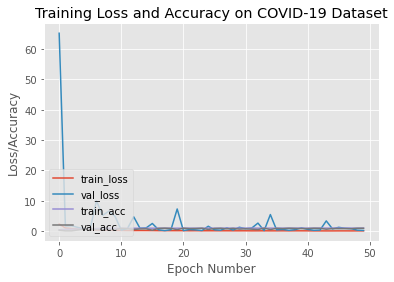

<Figure size 1440x1440 with 0 Axes>

In [33]:
N = EPOCHS
plt.style.use("ggplot")

plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch Number")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.figure(figsize=(20,20))

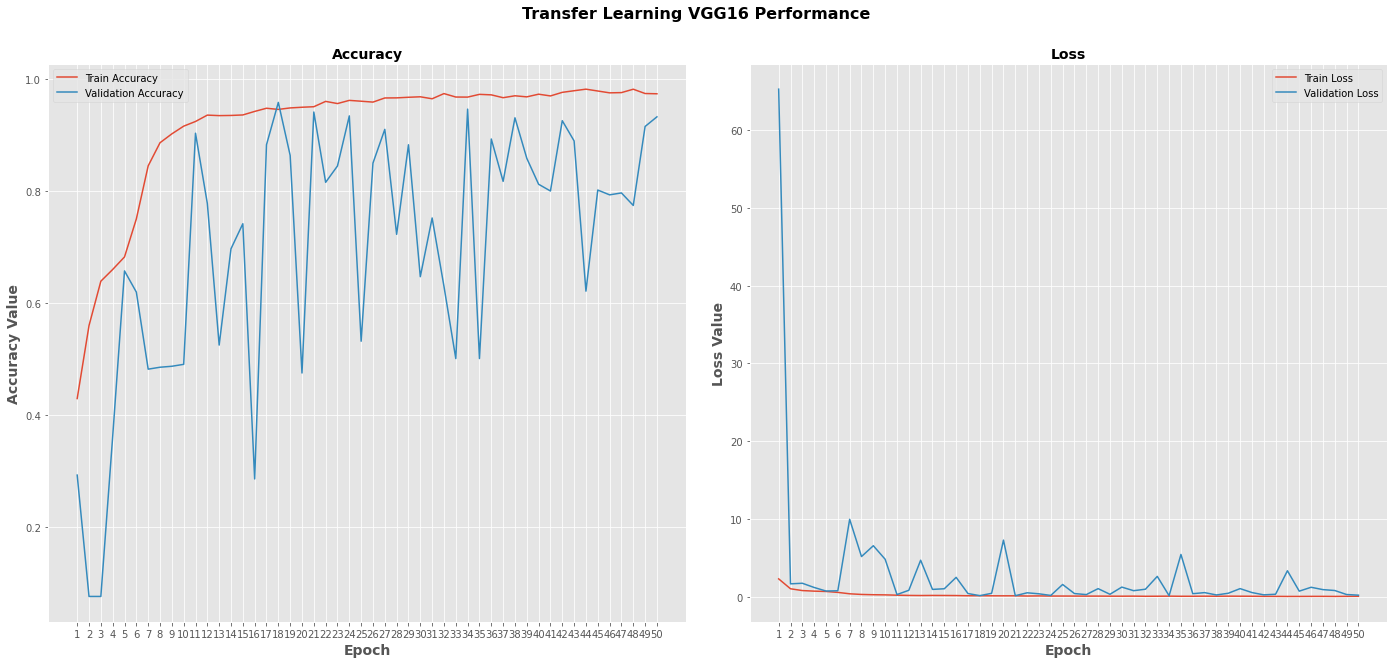

In [34]:
from sklearn.metrics import accuracy_score
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
t = f.suptitle('Transfer Learning VGG16 Performance', fontsize=16,fontweight='bold')
f.subplots_adjust(top=0.9, wspace=0.1)

max_epoch = len(H.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, H.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, H.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 1))
ax1.set_ylabel('Accuracy Value',fontsize=14,fontweight='bold')
ax1.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax1.set_title('Accuracy', fontsize=14,fontweight='bold')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, H.history['loss'], label='Train Loss')
ax2.plot(epoch_list, H.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 1))
ax2.set_ylabel('Loss Value',fontsize=14,fontweight='bold')
ax2.set_xlabel('Epoch',fontsize=14,fontweight='bold')
ax2.set_title('Loss',fontsize=14,fontweight='bold')
l2 = ax2.legend(loc="best")

In [35]:
# Load best model
# model= load_model('model.h5')

# Result on train

In [36]:
predIdxs = model_RN50.predict(trainX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.99190   1.00000   0.99593      1225
      Normal    0.98782   0.90680   0.94558      1073
   Pneumonia    0.91768   0.98420   0.94978      1076

    accuracy                        0.96532      3374
   macro avg    0.96580   0.96367   0.96376      3374
weighted avg    0.96693   0.96532   0.96520      3374



# Result on test

In [37]:
predIdxs = model_RN50.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.84000   0.95455   0.89362        44
      Normal    0.99163   0.88433   0.93491       268
   Pneumonia    0.90068   0.97770   0.93761       269

    accuracy                        0.93287       581
   macro avg    0.91077   0.93886   0.92205       581
weighted avg    0.93804   0.93287   0.93303       581



In [38]:
import sklearn.metrics as metrics
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

<function matplotlib.pyplot.show(*args, **kw)>

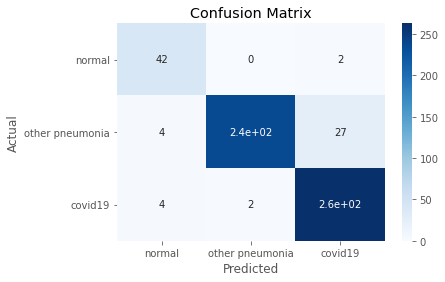

In [39]:
plt.figure()

ax = plt.subplot()

ax.set_title('Confusion Matrix')
pred = model_RN50.predict(testX)
pred=np.argmax(pred,axis=1)
# pred = model.predict_classes(X_test)
Y_TEST = np.argmax(testY, axis =1)
cm = metrics.confusion_matrix(Y_TEST,pred)
classes=['normal', 'other pneumonia', 'covid19']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show

In [40]:
img_size = (224,224)
dir_name = '../input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19'
img_list = glob.glob(dir_name + '/*')

list_covid = []
for img in img_list:
    temp_img = load_img(img,grayscale=True,target_size=(img_size))
    temp_img_array = img_to_array(temp_img) /255
    list_covid.append(temp_img_array)
list_covid = np.array(list_covid)
list_covid2 = list_covid.reshape(-1,50176)
df_covid=pd.DataFrame(list_covid2)
df_covid['label'] = np.full(df_covid.shape[0],2)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [41]:
img_size = (224,224)
dir_name2 = '../input/covid19-radiography-database/COVID-19 Radiography Database//NORMAL'
img_list2 = glob.glob(dir_name2 + '/*')

list_normal = []
for img in img_list2[:150]:
    temp_img = load_img(img,grayscale=True,target_size=(img_size))
    temp_img_array = img_to_array(temp_img) /255
    list_normal.append(temp_img_array)
list_normal = np.array(list_normal)
list_normal2 = list_normal.reshape(-1,50176)
df_normal=pd.DataFrame(list_normal2)
df_normal['label'] = np.full(df_normal.shape[0],0)

In [42]:
img_size = (224,224)
dir_name3 = '../input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia'
img_list3 = glob.glob(dir_name3 + '/*')

list_others = []
for img in img_list3[:150]:
    temp_img = load_img(img,grayscale=True,target_size=(img_size))
    temp_img_array = img_to_array(temp_img) /255
    list_others.append(temp_img_array)
list_others = np.array(list_others)
list_others2 = list_others.reshape(-1,50176)
df_others=pd.DataFrame(list_others2)
df_others['label'] = np.full(df_others.shape[0],1)

In [43]:
Df = pd.concat([df_covid, df_normal , df_others], ignore_index=True)

In [44]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

PRED = to_categorical(pred)
y = Df['label'].values
# Binarize the output
y = label_binarize(y, classes=[0,1,2])
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
       fpr[i], tpr[i], _ = roc_curve(testY[:,i], PRED[:,i])
       roc_auc[i] = auc(fpr[i], tpr[i])

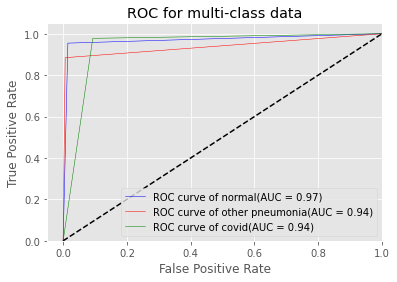

In [45]:
colors = ['blue', 'red', 'green']
cls = {0:'normal', 1:'other pneumonia', 2:'covid'}
for i, color ,c in zip(range(n_classes), colors, cls.values()):
    plt.plot(fpr[i], tpr[i], color=color, lw=0.5,
             label='ROC curve of '+c+ '(AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--',linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class data')
plt.legend(loc="lower right")
plt.show()